In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import urllib 
import shutil

import requests
import pandas as pd 
import numpy as np 
from tqdm.auto import tqdm

import matplotlib.pyplot as plt  
import matplotlib as mpl

from gspread_pandas import Spread, Client

from gps_analysis import files, splits, geodesy, garmin, ludum, utils

In [3]:
api = ludum.LudumClient.from_credentials(
    "ludum_credentials.json"
).login()

In [4]:
agenda = api.load_agenda(
    start_date='2021-09-01',
    end_date='2022-04-03',
    # days=100
)

In [4]:
agenda = api.load_agenda(
    start_date='2022-05-20',
    end_date='2022-05-21',
    # days=100
)

In [5]:
sessions, errors = utils.map_concurrent(
    api.get_session_data, 
    dict(zip(agenda.id, zip(agenda.id))), 
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
session_info, session_files = ludum.extract_session_data(sessions)
rowers = ludum.extract_rowers(sessions)
rowing_files = session_files.loc[
    (session_files.session_individual_files_data_sport_name == 'Rowing')
].reset_index(drop=True)

In [8]:
rowing_activity_data, errors = utils.map_concurrent(
    ludum.download_ludum_data,
    {
        (row.session_id, row.full_name): (row,)
        for _, row in rowing_files.iterrows()
    }, 
    max_workers=4,
    overwrite=False,
    file_cols=['session_individual_files_data_gps_file'],
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
ludum_data_path = Path("ludum_data/session_individual_files_gps_file/")

session_activity_id = session_files.set_index([
    'session_individual_files_data_session_id', 'id'
]).session_individual_files_data_id
activity_data, activity_info, read_errors = ludum.read_ludum_path(
    ludum_data_path, session_activity_id.index
)
activity_data['activity_id'] = session_activity_id.loc[
    activity_data.index.droplevel(-1)
].values
activity_info['activity_id'] = session_activity_id.loc[activity_info.index].values

activity_data = activity_data.reset_index().set_index(
    ['activity_id', 'data_point']
)
activity_info = activity_info.reset_index().set_index('activity_id')

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
best_times = activity_data.groupby(level=0).apply(
    lambda x: splits.find_all_best_times(x.droplevel(0))
)

In [18]:
activity_data['timeDelta'] = - activity_data.timeElapsed.diff(-1)
activity_data.loc[
    (activity_data.timeDelta < pd.Timedelta(0)) 
    | activity_data.timeDelta.isna(),
    'timeDelta'
] = pd.Timedelta(0)

In [17]:
session_cols = [
    'session_info.start_time',
    'session_info.total_distance',
    'session_info.avg_cadence',
    'session_info.avg_heart_rate',
    'user_id', 
]
ludum_activities = activity_info[session_cols].join(
    session_files.set_index('session_individual_files_data_id')[
        ['session_id', 'id', 'session_name', 'full_name']
    ], 
)
ludum_activities['startTime'] = pd.to_datetime(ludum_activities['session_info.start_time'], unit='s')
ludum_activities['startTimeLocal'] = ludum_activities.startTime.dt.strftime("%Y-%m-%d %H:%M")
ludum_activities['distance'] = ludum_activities['session_info.total_distance'] 
ludum_activities['total distance'] = ludum_activities.distance / 1000

loc_dists, locs = splits.get_distance_to_locations(activity_data)
closest_locations = splits.get_closest_locations(loc_dists.groupby(level=0).min(), locs)
ludum_activities['location'] = closest_locations.location

rowers['activity_id'] = ludum_activities.reset_index().set_index(
    ['user_id', 'session_id']
).reindex(rowers.index).activity_id
rower_activities = rowers.loc[rowers.activity_id.notna()].copy()
rower_activities.loc[:, 'activity_id'] = rower_activities.activity_id.astype(int)
rower_activities.set_index('activity_id', inplace=True)

ludum_activities = ludum_activities.join(
    rower_activities[["boat_type.data.name", "gmt_score.data.gmt_score"]], 
    rsuffix='_r')
pgmts = rower_activities.groupby("boat_type.data.name")["gmt_score.data.gmt_score"].first()

ludum_activities["boat_class"] = ludum_activities["boat_type.data.name"].fillna('8+')
ludum_activities["gmt_split"] = ludum_activities["gmt_score.data.gmt_score"].fillna(pgmts['8+']) / 4

In [234]:
activity_data.heart_rate.min(), activity_data.heart_rate.max()

(0.0, 204.0)

In [161]:
hrs = pd.RangeIndex(60, 200, 1)
cumtime_at_hr = activity_data.groupby(
    ['activity_id', 'heart_rate']
).timeDelta.sum().dt.total_seconds().unstack(
    fill_value=0
).sort_index(
    axis=1, ascending=False
).cumsum(1).sort_index(axis=1)[hrs] / 3600
cumtime_at_hr.columns = hrs 

rowers_cumtime_at_hr = cumtime_at_hr.join(
    ludum_activities[['full_name', 'startTime']]
).set_index(
    ['full_name', 'startTime']
)

In [176]:
import matplotlib.patheffects as pe

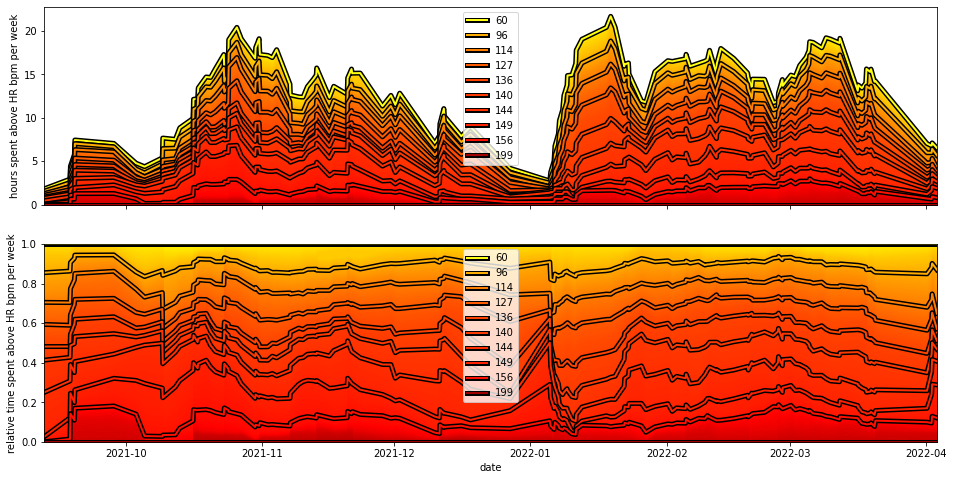

In [216]:
hr_colors = pd.DataFrame(
    plt.cm.get_cmap("hot_r")(hrs),
    index=hrs
)

rower_cumtime_at_hr = rowers_cumtime_at_hr.loc['Miranda Clements'].sort_index().rolling(
    pd.Timedelta(days=14), 
    min_periods=1
).sum()

rower_reltime = rower_cumtime_at_hr / rower_cumtime_at_hr.values[:, [0]]


f, (ax1, ax2) = plt.subplots(2, figsize=(16, 8), sharex=True)

base = pd.Series(0., index=rower_cumtime_at_hr.index)
for hr, time in rower_cumtime_at_hr.items():
    ax1.fill_between(
        base.index, base, time, color=hr_colors.loc[hr]
    )
    base = time

cumtime = rower_cumtime_at_hr.sum()
hr_to_plot = cumtime.index[::-1][
    cumtime[::-1].searchsorted(np.linspace(0, cumtime.max(), 10))
][::-1]
hr_to_plot

for hr in hr_to_plot:
    ax1.plot(
        base.index, rower_cumtime_at_hr[hr], label=hr,
        color=hr_colors.loc[hr],
        lw=2,
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()]
    )

# plt.yscale("log")
ax1.set_ylim(0, rower_cumtime_at_hr.values.max() * 1.05)
ax1.set_xlim(base.index[0], base.index[-1])

ax1.set_ylabel("hours spent above HR bpm per week")
# ax1.set_xlabel("date")

ax1.legend()

base = pd.Series(0., index=rower_cumtime_at_hr.index)
for hr, time in rower_reltime.items():
    ax2.fill_between(
        base.index, base, time, color=hr_colors.loc[hr]
    )
    base = time 

for hr in hr_to_plot:
    ax2.plot(
        base.index, rower_reltime[hr], label=hr,
        color=hr_colors.loc[hr],
        lw=2,
        path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()]
    )

# plt.yscale("log")
ax2.set_ylim(0, 1)
ax2.set_xlim(base.index[0], base.index[-1])

ax2.set_ylabel("relative time spent above HR bpm per week")
ax2.set_xlabel("date")
ax2.legend()

In [226]:
full_best_times = best_times.join(ludum_activities)
full_best_times['ipgmt'] = (
    full_best_times.split.dt.total_seconds() 
    / full_best_times.gmt_split
)
activity_fastest = full_best_times.loc[
    (full_best_times['total distance'] > 5) & 
    (full_best_times['total distance'] < 500)
].reset_index(0).groupby(
    ['full_name', 'location', 'startTime', 'activity_id', 'length']
)[['split', 'gmt_split', 'ipgmt']].min().sort_index().unstack()

distances = pd.Series(splits._STANDARD_DISTANCES).loc[
    activity_fastest.columns.levels[1]
].sort_values()

activity_fastest_splits = activity_fastest['split'][distances.index]
activity_fastest_pgmts = 1 / activity_fastest.ipgmt[distances.index]

rower_activity_counts = activity_fastest_splits.groupby(level=[0, 1]).size().sort_values(ascending=False)


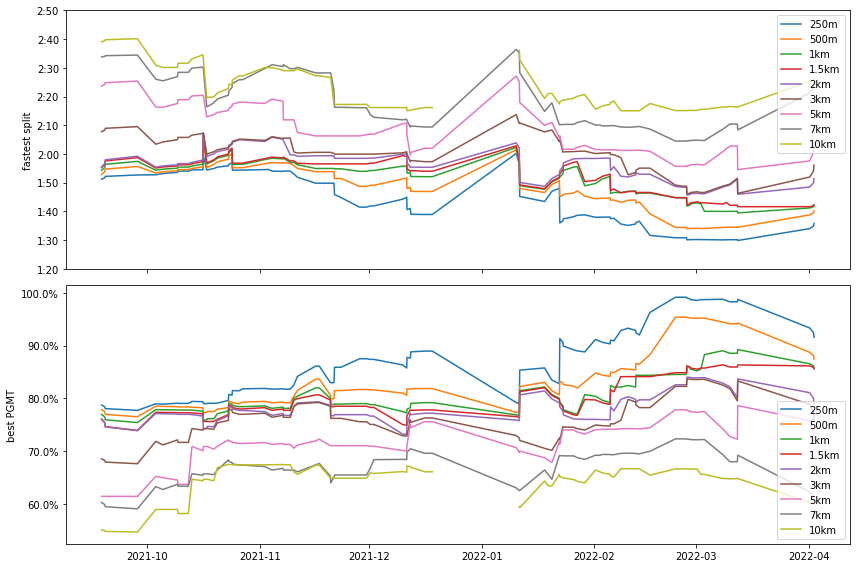

In [230]:
rower_loc = rower_activity_counts.index[1]
roll_days = 28

rower_fastest_splits = activity_fastest_splits.loc[
    rower_loc
].droplevel(1).apply(
    lambda x: x.dt.total_seconds()
)
rower_fastest_monthly_splits = rower_fastest_splits.rolling(
    pd.Timedelta(days=roll_days), 
    min_periods=3
).quantile(0.1)

rower_fastest_pgmts = activity_fastest_pgmts.loc[
    rower_loc
].droplevel(1)
rower_rolling_pgmts = rower_fastest_pgmts.rolling(
    pd.Timedelta(days=roll_days), 
    min_periods=3
).quantile(0.9)

f, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
for dist, best_splits in rower_fastest_monthly_splits.items():
    ax1.plot(
        best_splits.index,
        best_splits, 
        label=dist
    )

utils.format_yaxis_splits(ax1)
ax1.legend()
ax1.set_ylabel("fastest split")

for dist, best in rower_rolling_pgmts.items():
    ax2.plot(best.index, best * 100,  label=dist)

# utils.format_yaxis_splits(ax)
ax2.legend()
ax2.set_ylabel("best PGMT")
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
f.tight_layout()

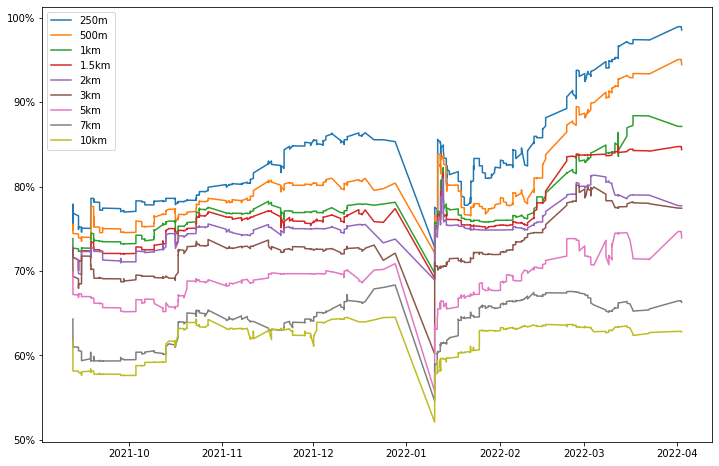

In [221]:
squad_best = full_best_times.loc[
    (full_best_times['total distance'] > 5) & 
    (full_best_times['total distance'] < 500)
].reset_index(0).groupby(
    ['location', 'startTime', 'activity_id', 'length']
)[['split', 'gmt_split', 'ipgmt']].min().sort_index().unstack()

squad_pgmts = (
    1 / squad_best.loc['ely'].ipgmt[distances.index]
).droplevel(-1).sort_index().rolling(
    pd.Timedelta(days=28), 
    min_periods=5
).quantile(0.8)

f, ax1 = plt.subplots(figsize=(12, 8))
for dist, best_splits in squad_pgmts.items():
    plt.plot(
        best_splits.index,
        best_splits * 100, 
        label=dist
    )
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
plt.legend()